In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import warnings
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from pyfish import fish_plot, process_data
# local import
from utils import read_mi, enrichment
from utils import ml_metrics, get_rbd_mutated
from utils import AFFINITY, ESCAPE, MOI

In [3]:
!wget --quiet -O escapecalculator.py https://raw.githubusercontent.com/jbloomlab/SARS2-RBD-escape-calc/main/escapecalculator.py

In [4]:
INTERESTING = set(MOI).union(AFFINITY).union(ESCAPE)

In [5]:
print(INTERESTING)

{18, 403, 406, 417, 681, 439, 440, 446, 447, 449, 452, 455, 456, 477, 484, 489, 493, 494, 496, 498, 501, 505, 506}


In [6]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        df.append(read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated_prefilter.tsv.gz',
                          name,
                          date=True))
        mutated = get_rbd_mutated('../out/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:38: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:38: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:38: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')


In [7]:
res = []
for name in sorted(df['name'].unique()):
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]
    
    o = enrichment(s, d_mutated[name])
    
    print(name)

    res.append(['actual', year, month, name,
                o[(o['type'] == 'original') &
                  (o['randomization'] == 'any_positions')]['odds-ratio'].values[0],
                o[(o['type'] == 'original') &
                  (o['randomization'] == 'any_positions')]['p-value'].values[0]])

    for odds_ratio, pvalue in o[(o['type'] == 'random') &
                                (o['randomization'] == 'any_positions')
                                        ][['odds-ratio', 'p-value']].values:
        res.append(['random', year, month, name, odds_ratio, pvalue])

r = pd.DataFrame(res,
                 columns=['set',
                          'year', 'month',
                          'name', 'odds-ratio',
                          'p-value'])

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


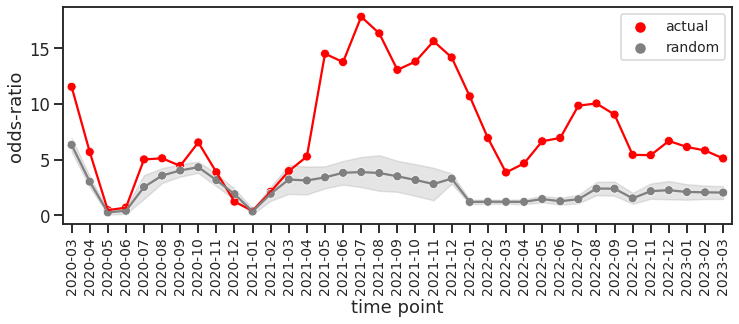

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='odds-ratio',
             hue='set',
             errorbar='sd',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
sns.scatterplot(data=r.groupby(['name', 'set'])[['odds-ratio']].mean().reset_index(),
                x='name',
                y='odds-ratio',
                hue='set',
                ax=ax,
                palette=['r', 'grey'])

plt.legend(facecolor='w', fontsize=14)

plt.xticks(rotation=90,
           fontsize=14)
plt.xlabel('time point')

plt.xlim(-0.5, r['name'].unique().shape[0] - 0.5)

plt.savefig('time_extra_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_extra_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

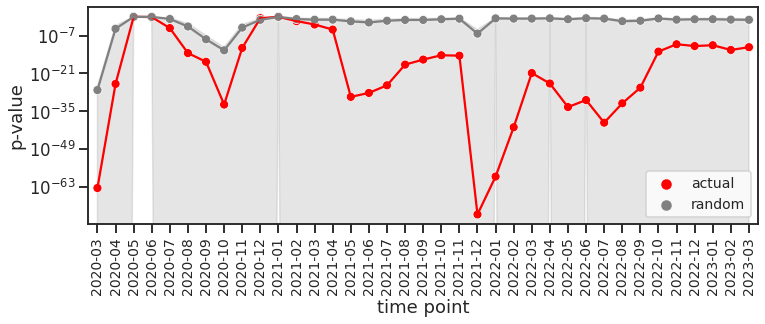

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='p-value',
             hue='set',
             errorbar='sd',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
sns.scatterplot(data=r.groupby(['name', 'set'])[['p-value']].mean().reset_index(),
                x='name',
                y='p-value',
                hue='set',
                ax=ax,
                palette=['r', 'grey'])

plt.xticks(rotation=90,
           fontsize=14)

plt.xlim(-0.5, r['name'].unique().shape[0] - 0.5)

plt.yscale('log')
plt.xlabel('time point')

plt.legend(facecolor='w', fontsize=14)

plt.savefig('time_extra_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_extra_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [10]:
res = []
for name in sorted(df['name'].unique()):
    print(name)
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    f1, f2, f3, f4, pr_auc, roc_auc = ml_metrics(s,
                                                 mutated=d_mutated[name],
                                                 shuffle=False)
    res.append(['actual', year, month, name,
                f1, f2, f3, f4, pr_auc, roc_auc])

    # for i in range(100):
    #     with warnings.catch_warnings():
    #         warnings.simplefilter("ignore")
    #         f1, f2, f3, f4, pr_auc, roc_auc = ml_metrics(s,
    #                                                      mutated=d_mutated[name],
    #                                                      shuffle=True)
    #     res.append(['random', year, month, name,
    #                 f1, f2, f3, f4, pr_auc, roc_auc])

r1 = pd.DataFrame(res,
                  columns=['set',
                           'year', 'month',
                           'name', 1, 2, 3, 4, 'pr_auc', 'roc_auc'])

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


In [11]:
r1 = r1.set_index(['set',
                   'year', 'month',
                   'name']).stack().reset_index().rename(columns={'level_4': 'test',
                                                                  0: 'value'})

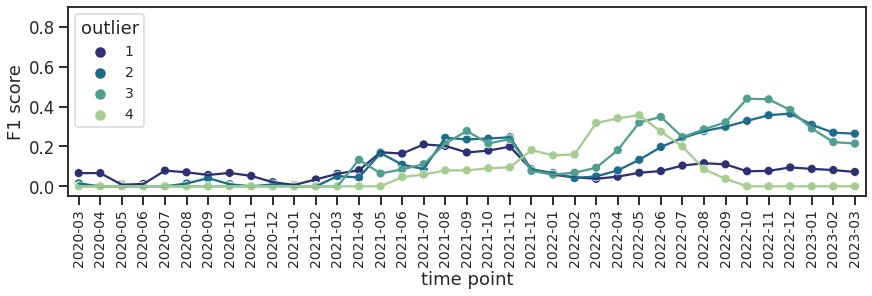

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4),
                         constrained_layout=True)

sns.lineplot(data=r1[(r1['test'].isin(range(1, 5))) &
                     (r1['set'] == 'actual')],
             x='name',
             y='value',
             hue='test',
             errorbar='sd',
             ax=ax,
             legend=False,
             palette='crest_r'
            )
sns.scatterplot(data=r1[(r1['test'].isin(range(1, 5))) &
                        (r1['set'] == 'actual')],
                x='name',
                y='value',
                hue='test',
                ax=ax,
                palette='crest_r'
               )

ax.legend(facecolor='w', fontsize=14, title='outlier')

ax.set_xlim(-0.5, r1['name'].unique().shape[0] - 0.5)
ax.set_ylim(-0.05, 0.9)

ax.set_ylabel('F1 score')
ax.set_xlabel('time point')

plt.xticks(rotation=90,
           fontsize=14)

plt.savefig('time_extra_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_extra_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [13]:
r1[(r1['test'] == 1) &
   (r1['year'] > 2020) &
   (r1['year'] < 2023)].groupby(['name', 'set'])['value'].max()

name     set   
2021-01  actual    0.006957
2021-02  actual    0.034602
2021-03  actual    0.062992
2021-04  actual    0.080586
2021-05  actual    0.170833
2021-06  actual    0.164271
2021-07  actual    0.210169
2021-08  actual    0.202765
2021-09  actual    0.169884
2021-10  actual    0.179245
2021-11  actual    0.198895
2021-12  actual    0.084280
2022-01  actual    0.058322
2022-02  actual    0.045399
2022-03  actual    0.037803
2022-04  actual    0.048527
2022-05  actual    0.068104
2022-06  actual    0.076613
2022-07  actual    0.104152
2022-08  actual    0.115972
2022-09  actual    0.110236
2022-10  actual    0.075556
2022-11  actual    0.077496
2022-12  actual    0.094845
Name: value, dtype: float64

In [14]:
r1[(r1['test'] == 2) &
   (r1['year'] > 2020) &
   (r1['year'] < 2023)].groupby(['name', 'set'])['value'].max()

name     set   
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.051282
2021-04  actual    0.044444
2021-05  actual    0.166667
2021-06  actual    0.108696
2021-07  actual    0.086957
2021-08  actual    0.243478
2021-09  actual    0.235294
2021-10  actual    0.239437
2021-11  actual    0.246154
2021-12  actual    0.085366
2022-01  actual    0.066879
2022-02  actual    0.041422
2022-03  actual    0.049954
2022-04  actual    0.079814
2022-05  actual    0.133169
2022-06  actual    0.197343
2022-07  actual    0.242424
2022-08  actual    0.276730
2022-09  actual    0.298701
2022-10  actual    0.328358
2022-11  actual    0.356589
2022-12  actual    0.365079
Name: value, dtype: float64

In [15]:
r1[(r1['test'] == 3) &
   (r1['year'] > 2020) &
   (r1['year'] < 2023)].groupby(['name', 'set'])['value'].max()

name     set   
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.133333
2021-05  actual    0.064516
2021-06  actual    0.085106
2021-07  actual    0.111111
2021-08  actual    0.214286
2021-09  actual    0.277778
2021-10  actual    0.214876
2021-11  actual    0.236842
2021-12  actual    0.077253
2022-01  actual    0.058795
2022-02  actual    0.068357
2022-03  actual    0.093385
2022-04  actual    0.181425
2022-05  actual    0.320000
2022-06  actual    0.348315
2022-07  actual    0.246914
2022-08  actual    0.285714
2022-09  actual    0.321168
2022-10  actual    0.439560
2022-11  actual    0.436364
2022-12  actual    0.382979
Name: value, dtype: float64

In [16]:
r1[(r1['test'] == 4) &
   (r1['year'] > 2020) &
   (r1['year'] < 2023)].groupby(['name', 'set'])['value'].max()

name     set   
2021-01  actual    0.000000
2021-02  actual    0.000000
2021-03  actual    0.000000
2021-04  actual    0.000000
2021-05  actual    0.000000
2021-06  actual    0.046512
2021-07  actual    0.058824
2021-08  actual    0.080000
2021-09  actual    0.080000
2021-10  actual    0.090909
2021-11  actual    0.095238
2021-12  actual    0.181818
2022-01  actual    0.155340
2022-02  actual    0.160000
2022-03  actual    0.317949
2022-04  actual    0.341176
2022-05  actual    0.356688
2022-06  actual    0.274194
2022-07  actual    0.200000
2022-08  actual    0.085714
2022-09  actual    0.037736
2022-10  actual    0.000000
2022-11  actual    0.000000
2022-12  actual    0.000000
Name: value, dtype: float64